In [1]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torchtext.data as ttdata
from torchtext.vocab import FastText

from tqdm import tqdm
from caffe2.python import core
from torch.utils.tensorboard import SummaryWriter

import MeCab

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:" + device)

batch_size = 32
lr = 0.06
weight_decay = 0.0001
n_epoch = 30
eval_interval = 10

load_model = False
use_vectors = False
data_path = "./data/review_50.4k.json"
output_path = "exps/attn1/"
if not (os.path.exists(output_path)): os.mkdir(output_path)

writer = SummaryWriter(output_path + "logs")

device:cuda


In [3]:
def tokenize(text):
    return text.split(" ")

In [4]:
label_field = ttdata.Field(sequential=False, unk_token=None)
text_field = ttdata.Field(sequential=True, lower=True, tokenize=tokenize)

dataset = ttdata.TabularDataset(data_path, format='json', fields={'stars' : ('label', label_field) , 'text':('text', text_field)})

In [5]:
label_field.build_vocab(dataset)

vectors = FastText(language='en') if use_vectors else None
text_field.build_vocab(dataset, vectors=vectors)

Items: 504000
Vocabs: 928445


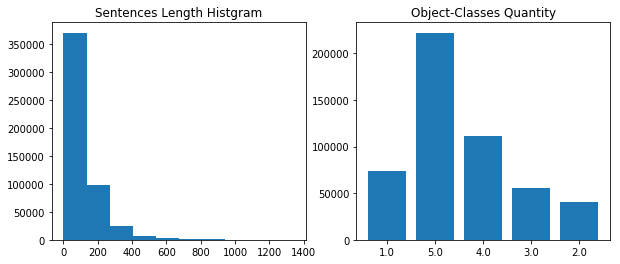

In [6]:
length_list = [len(e.text) for e in dataset]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(length_list, bins=10)
axL.set_title("Sentences Length Histgram")

freqs = label_field.vocab.freqs
axR.bar(range(len(freqs)), list(freqs.values()), tick_label=list(freqs.keys()))
axR.set_title("Object-Classes Quantity")

print("Items: {}".format(len(dataset)))
print("Vocabs: {}".format(len(text_field.vocab)))

In [7]:
train_data, test_data = dataset.split(500000/504000)
valid_data, test_data = test_data.split(0.5)

train_iter = ttdata.BucketIterator(train_data, batch_size=batch_size, device=device, shuffle=True)
valid_iter = ttdata.BucketIterator(valid_data, batch_size=batch_size, device=device, shuffle=True)
test_iter = ttdata.BucketIterator(test_data, batch_size=1, device=device, shuffle=True)

In [8]:
class Attn(nn.Module):
    def __init__(self, in_dim, out_dim, middle_dim=350):
        super(Attn, self).__init__()
        self.fc1 = nn.Linear(in_dim, middle_dim)
        self.fc2 = nn.Linear(middle_dim, out_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = x.permute(0, 2, 1)
        x = torch.softmax(x, dim=2)
        return x

class Net(nn.Module):
    def __init__(self, vocab_len, out_dim=2, embed_dim=100, hidden_dim=300, attn_out_dim=10, middle_dim=2000, num_layers=1, dropout=0.5, vocab_vectors=None):
        super(Net, self).__init__()
        if vocab_vectors is not None: embed_dim = vocab_vectors.shape[1]
        self.embed = nn.Embedding(vocab_len, embed_dim)
        if vocab_vectors is not None: self.embed.weight.data.copy_(vocab_vectors)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, bidirectional=True)

        self.attn = Attn(hidden_dim*2, attn_out_dim)
        self.fc1 = nn.Linear(attn_out_dim*hidden_dim*2, middle_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(middle_dim, out_dim)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_dim).to(device, dtype=torch.float)
        cell = torch.zeros(self.num_layers*2, batch_size, self.hidden_dim).to(device, dtype=torch.float)
        return (hidden, cell)
        
    def forward(self, x, h_c):
        emb = self.embed(x)
        seq_len, batch_size = x.shape
        x, h_c = self.lstm(emb, h_c)
        x = x.permute(1, 0, 2)
        attns = self.attn(x)
        x = torch.bmm(attns, x)
        x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x, attns

vectors = text_field.vocab.vectors
net = Net(len(text_field.vocab), out_dim=len(label_field.vocab), vocab_vectors=vectors).to(device)
if(load_model):
    net.load_state_dict(torch.load(output_path + "model"))

learning_info = "Batch Size: {}\n\nLearning Rate: {}\n\nClasses: {}\n\nWeight Decay: {}\n\n".format(batch_size, lr, len(label_field.vocab), weight_decay)
learning_info += re.sub("\n", "\n\n", str(net))
writer.add_text("network_info", learning_info)

print(net)

Net(
  (embed): Embedding(928445, 100)
  (lstm): LSTM(100, 300, bidirectional=True)
  (attn): Attn(
    (fc1): Linear(in_features=600, out_features=350, bias=True)
    (fc2): Linear(in_features=350, out_features=10, bias=True)
  )
  (fc1): Linear(in_features=6000, out_features=2000, bias=True)
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=2000, out_features=5, bias=True)
)


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

learning_info += re.sub("\n", "\n\n", str(criterion)) + "\n\n"
learning_info += re.sub("\n", "\n\n", str(optimizer)) + "\n\n"
writer.add_text("network_info", learning_info)

In [10]:
def train(epoch):
    net.train()
    loss_sum = 0
    preds = []
    targets = []
    for index, data in enumerate(tqdm(train_iter, "Epoch-{}".format(epoch))):
        text = data.text
        target = data.label
        
        optimizer.zero_grad()
        h = net.init_hidden(data.batch_size)
        out, _ = net(text, h)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        preds += [o.argmax().item() for o in out]
        targets += [t.item() for t in target]
    train_loss = loss_sum / len(train_iter)
    writer.add_scalar('train/loss', train_loss, epoch + 1)
    accuracy = metrics.accuracy_score(targets, preds)
    writer.add_scalar('train/accuracy', accuracy, epoch + 1)
    return train_loss
    
def validation(epoch):
    net.eval()
    loss_sum = 0
    preds = []
    targets = []
    for data in iter(valid_iter):
        text = data.text
        target = data.label
        h = net.init_hidden(data.batch_size)
        out, _ = net(text, h)
        loss = criterion(out, target)
        loss_sum += loss.item()
        preds += [o.argmax().item() for o in out]
        targets += [t.item() for t in target]
    valid_loss = loss_sum / len(valid_iter)
    writer.add_scalar('validation/loss', valid_loss, epoch + 1)
    accuracy = metrics.accuracy_score(targets, preds)
    writer.add_scalar('validation/accuracy', accuracy, epoch + 1)
    return valid_loss

def eval(epoch):
    net.eval()
    loss_sum = 0
    losses = []
    preds = []
    targets = []
    for data in iter(test_iter):
        text = data.text
        target = data.label
        h = net.init_hidden(data.batch_size)
        out, _ = net(text, h)
        loss_sum += criterion(out, target)
        
        losses += [criterion(out, target).item()]
        
        preds += [o.argmax().item() for o in out]
        targets += [t.item() for t in target]
    test_loss = loss_sum / len(test_iter)
    # print("Test Loss: {}".format(test_loss))
    
    greater_loss_indexes = np.argsort(losses)[-10:]
    report = metrics.classification_report(targets, preds, labels=range(len(label_field.vocab)), target_names=list(label_field.vocab.itos), output_dict=True)
    report = pandas.DataFrame(report)
    with open(output_path + "report_{}.tsv".format(epoch), 'w') as file:
        file.write(report.to_csv(sep="\t"))

In [ ]:
for epoch in range(n_epoch):
    train_loss = train(epoch)
    valid_loss = validation(epoch)
    # print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch, train_loss, valid_loss))
    writer.export_scalars_to_json(output_path + "all_scalars.json")
    if(epoch % eval_interval == 0):
        eval(epoch)

writer.close()

Epoch-0: 100%|██████████| 15625/15625 [21:13<00:00, 12.27it/s]
/home/sakashita/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Epoch-1:  77%|███████▋  | 12059/15625 [16:26<04:31, 13.16it/s]

In [ ]:
torch.save(net.state_dict(), output_path + "model")